## Import Libraries and Data

In [384]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
data = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

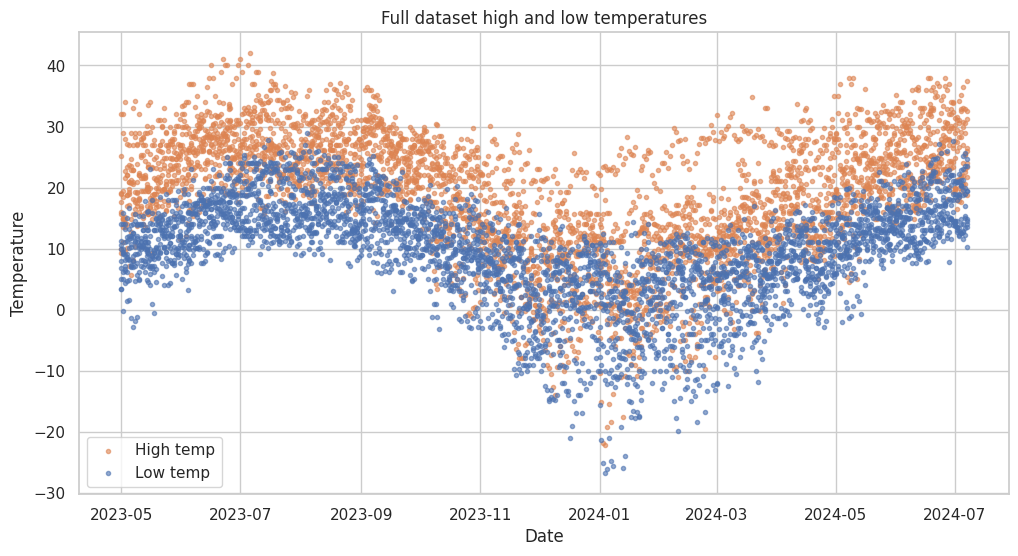

In [385]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(data.index, data['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(data.index, data['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [386]:
print(data.shape)
data.isnull().sum()

(3906, 27)


location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [387]:
data.duplicated().sum()

0

In [388]:
# Drop Columns of No Interest
df = data.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

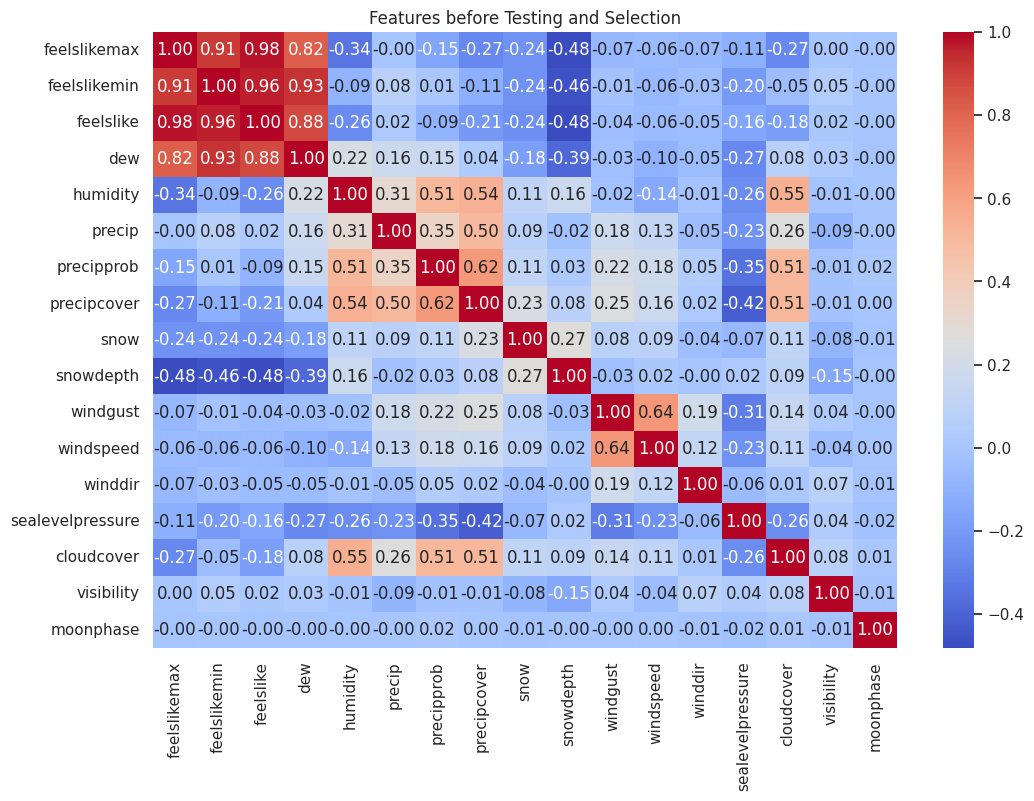

In [389]:
all_features = df[['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

df = df.select_dtypes(include=['number'])
correlation_matrix = all_features.corr()
plt.figure(figsize=(12, 8))
plt.title("Features before Testing and Selection")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Feature Selection

In [390]:
# Define the DataFrame with combined highly correlated features for tempmax and tempmin
df['feelslike_max_combined'] = df[['feelslikemax', 'feelslike']].mean(axis=1)
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Recalculate the features DataFrame without the original features tempmax
features_combined_max = df[['feelslike_max_combined', 'dew_humidity', 'snow', 'snowdepth', 'visibility']]

# Recalculate the features DataFrame without the original features tempmin
features_combined_min = df[['feelslike_min_combined', 'dew_humidity', 'precipcover', 'snowdepth', 'visibility']]


In [391]:
""" Addressing Multicollinearity with Variance Inflation Factor"""
# Calculate VIF for each feature in tempmax
vif_data_max = pd.DataFrame()
vif_data_max["tempmax feature"] = features_combined_max.columns
vif_data_max["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Calculate VIF for each feature in tempmin
vif_data_min = pd.DataFrame()
vif_data_min["tempmin feature"] = features_combined_min.columns
vif_data_min["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

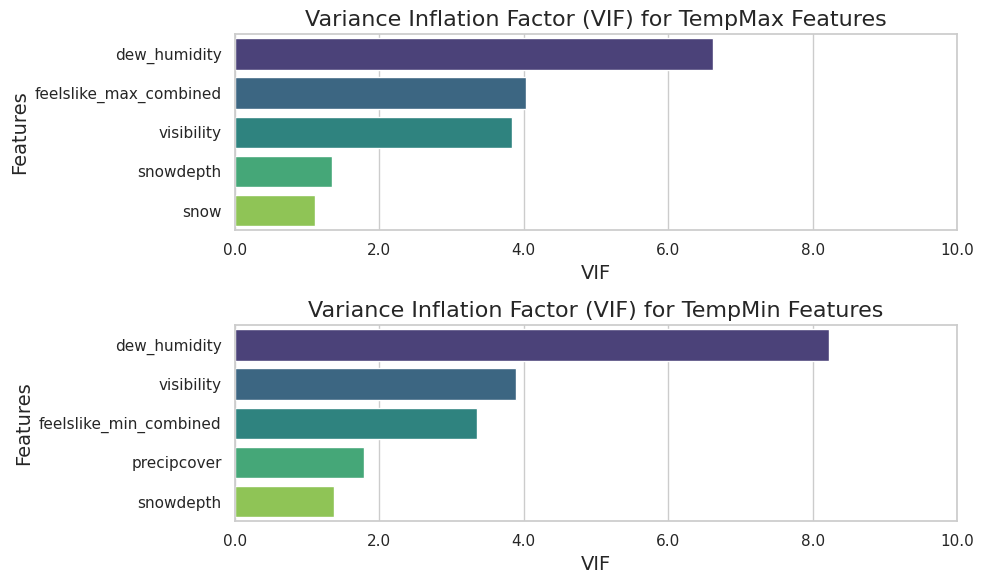

In [392]:
# Plotting the VIF results for tempmax and tempmin as subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
sns.set(style="whitegrid")

# VIF for TempMax Features
sns.barplot(x="VIF", y="tempmax feature", hue="tempmax feature", dodge=False, data=vif_data_max.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[0], legend=False)
axes[0].set_title('Variance Inflation Factor (VIF) for TempMax Features', fontsize=16)
axes[0].set_xlabel('VIF', fontsize=14)
axes[0].set_ylabel('Features', fontsize=14)
axes[0].set_xlim(0, 10)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# VIF for TempMin Features
sns.barplot(x="VIF", y="tempmin feature", hue="tempmin feature", dodge=False, data=vif_data_min.sort_values(by="VIF", ascending=False), palette="viridis", ax=axes[1], legend=False)
axes[1].set_title('Variance Inflation Factor (VIF) for TempMin Features', fontsize=16)
axes[1].set_xlabel('VIF', fontsize=14)
axes[1].set_ylabel('Features', fontsize=14)
axes[1].set_xlim(0, 10)
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust layout
plt.tight_layout()
plt.show()

## Hypothesis
"A higher dew point likely predicts a higher temperature across locations, making dew point a reliable temperature predictor irrespective of geography."

## Train-Validate-Test Split
### Translate Hypothesis to Testable Statements/Validate Features

In [393]:
# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Define feature set with combined features
X_max = ['feelslike_max_combined', 'dew_humidity', 'snow', 'snowdepth']

X_min = ['feelslike_min_combined', 'dew_humidity', 'snowdepth']


In [394]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

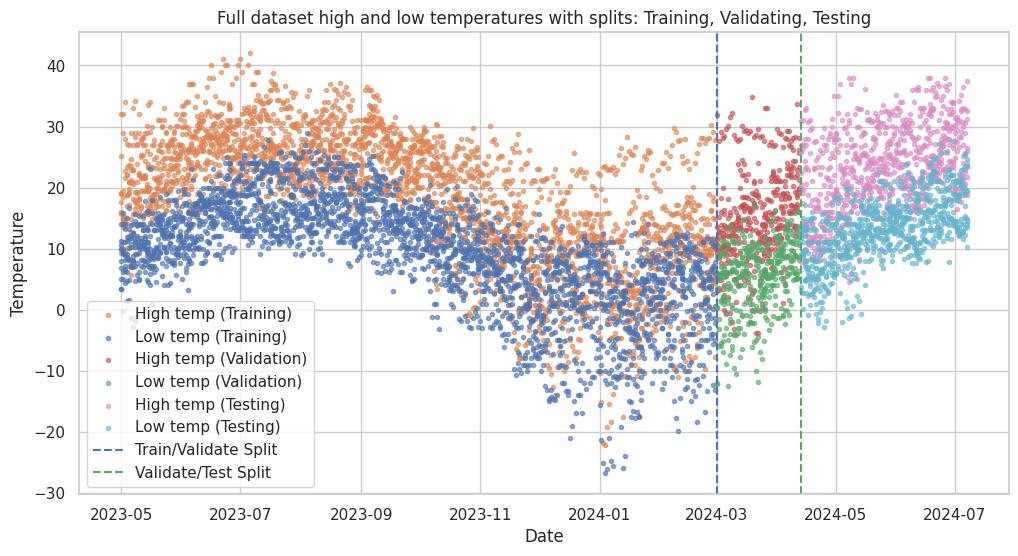

In [395]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [396]:
# Define target variables
y_train_max = train['tempmax']
y_train_min = train['tempmin']
y_validate_max = validate['tempmax']
y_validate_min = validate['tempmin']
y_test_max = test['tempmax']
y_test_min = test['tempmin']

# Define feature sets tempmax
X_train_max = train[X_max]
X_validate_max = validate[X_max]
X_test_max = test[X_max]

# Define feature sets tempmin
X_train_min = train[X_min]
X_validate_min = validate[X_min]
X_test_min = test[X_min]

## Model Training and Evaluation
### Chose Ridge because of regularization needs to address overfitting after model cross validation

In [397]:
# Function to evaluate model with robust error metrics
def evaluate_model(X_train, y_train, X_test, y_test, model_name):
    # Fit the model using statsmodels for detailed analysis with robust standard errors
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    model_sm = sm.OLS(y_train, X_train_sm).fit(cov_type='HC3')

    # Predictions
    y_train_pred = model_sm.predict(X_train_sm)
    y_test_pred = model_sm.predict(X_test_sm)

    # Goodness of fit
    print(f"Model Summary for {model_name}:")
    print(model_sm.summary())

    # Error metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f'Train RMSE for {model_name}: {train_rmse}, Test RMSE: {test_rmse}')
    print(f'Train MAE for {model_name}: {train_mae}, Test MAE: {test_mae}')
    print(f'Train R² for {model_name}: {train_r2}, Test R²: {test_r2}')

    # Multicollinearity
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_train.columns
    vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    print(f"VIF for {model_name}:\n", vif_data)

    # Residual analysis
    residuals = y_train - y_train_pred

    # Create subplots for residual analysis, Q-Q plot, and autocorrelation of residuals
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Residuals vs Predicted
    axs[0].scatter(y_train_pred, residuals)
    axs[0].axhline(0, color='red', linestyle='--')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Residuals')
    axs[0].set_title(f'Residuals vs Predicted for {model_name}')

    # Q-Q Plot
    qqplot(residuals, line='s', ax=axs[1])
    axs[1].set_title(f'Q-Q Plot of Residuals for {model_name}')

    # Autocorrelation of Residuals
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[2])
    axs[2].set_title(f'Autocorrelation of Residuals for {model_name}')

    plt.tight_layout()
    plt.show()


In [398]:
# Initialize the scalers
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler

# Robust scaling the feature variables
scaler_max = RobustScaler()
scaler_min = RobustScaler()

# Fit and transform the training data
X_train_max_scaled = scaler_max.fit_transform(X_train_max)
X_train_min_scaled = scaler_min.fit_transform(X_train_min)

# Transform the test data using the same scaler
X_test_max_scaled = scaler_max.transform(X_test_max)
X_test_min_scaled = scaler_min.transform(X_test_min)

# Hyperparameter tuning using GridSearchCV for Ridge Regression
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# GridSearchCV for tempmax
ridge_max = Ridge()
grid_search_max = GridSearchCV(ridge_max, param_grid, cv=5, scoring='r2')
grid_search_max.fit(X_train_max_scaled, y_train_max)
best_alpha_max = grid_search_max.best_params_['alpha']

# GridSearchCV for tempmin
ridge_min = Ridge()
grid_search_min = GridSearchCV(ridge_min, param_grid, cv=5, scoring='r2')
grid_search_min.fit(X_train_min_scaled, y_train_min)
best_alpha_min = grid_search_min.best_params_['alpha']

# Initialize and fit the Ridge Regression model with best alpha for tempmax
ridge_model_max = Ridge(alpha=best_alpha_max)
ridge_model_max.fit(X_train_max_scaled, y_train_max)

# Make predictions on the test set for tempmax
y_pred_test_max = ridge_model_max.predict(X_test_max_scaled)

# Calculate R² for test set for tempmax
r2_test_max = r2_score(y_test_max, y_pred_test_max)
print(f"Ridge Regression Test R² for tempmax: {r2_test_max}")

# Initialize and fit the Ridge Regression model with best alpha for tempmin
ridge_model_min = Ridge(alpha=best_alpha_min)
ridge_model_min.fit(X_train_min_scaled, y_train_min)

# Make predictions on the test set for tempmin
y_pred_test_min = ridge_model_min.predict(X_test_min_scaled)

# Calculate R² for test set for tempmin
r2_test_min = r2_score(y_test_min, y_pred_test_min)
print(f"Ridge Regression Test R² for tempmin: {r2_test_min}")

# Calculate residuals
residuals_max = y_test_max - y_pred_test_max
residuals_min = y_test_min - y_pred_test_min


Ridge Regression Test R² for tempmax: 0.9716367251501942
Ridge Regression Test R² for tempmin: 0.9460037251070065


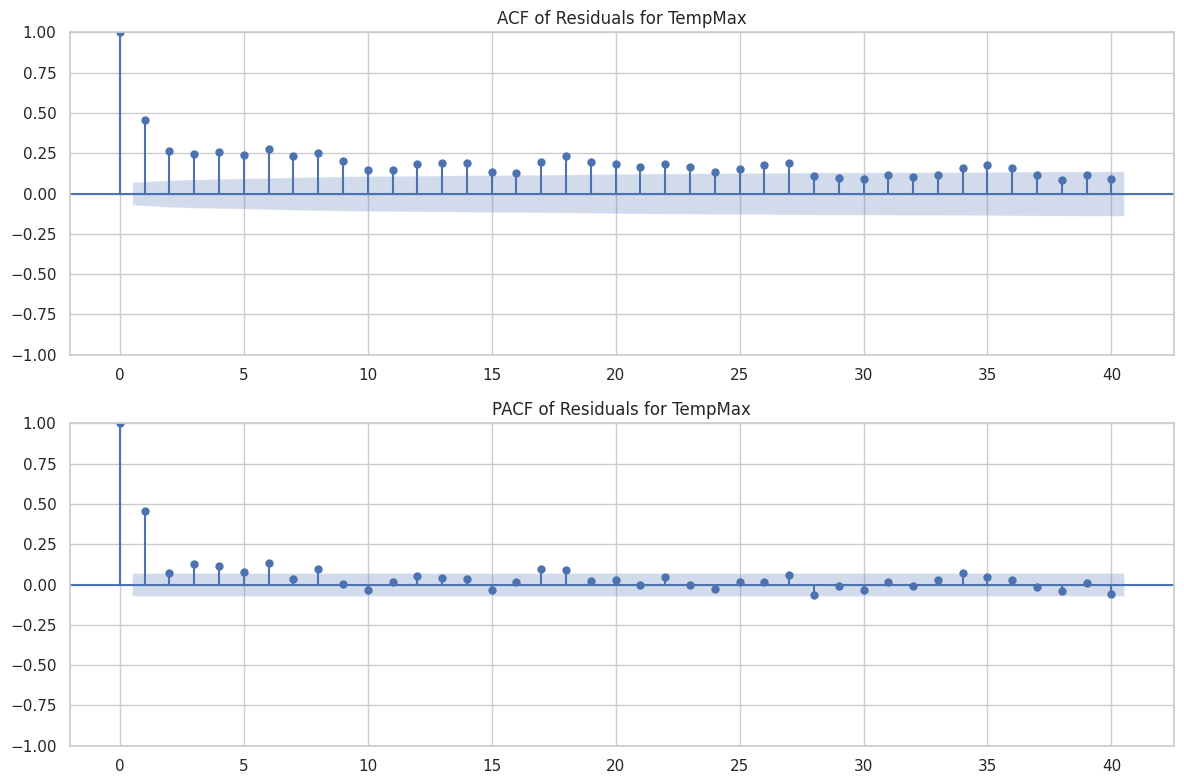

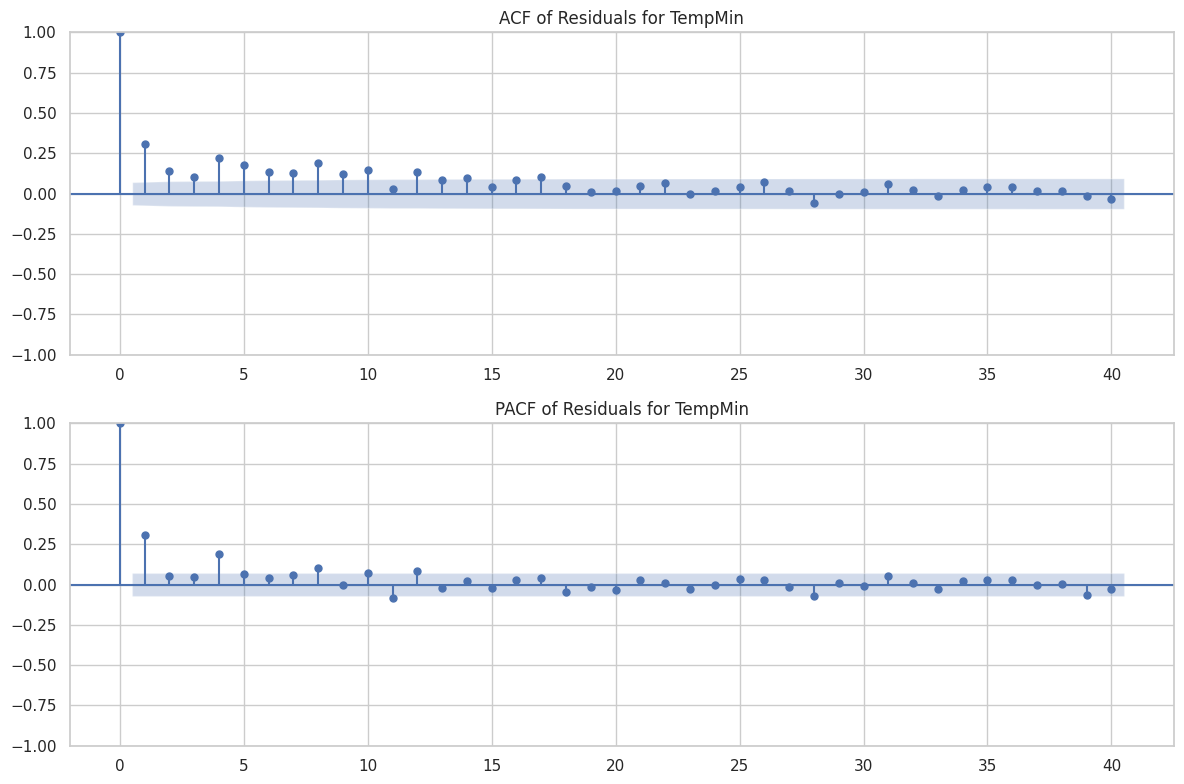

In [399]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF for TempMax residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals_max, lags=40, ax=ax[0], title='ACF of Residuals for TempMax')
plot_pacf(residuals_max, lags=40, ax=ax[1], title='PACF of Residuals for TempMax')
plt.tight_layout()
plt.show()

# ACF and PACF for TempMin residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals_min, lags=40, ax=ax[0], title='ACF of Residuals for TempMin')
plot_pacf(residuals_min, lags=40, ax=ax[1], title='PACF of Residuals for TempMin')
plt.tight_layout()
plt.show()


In [400]:
from statsmodels.tsa.stattools import adfuller

# Function to perform ADF test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. Data has a unit root and is non-stationary")
    print()

# Perform ADF test on target variables
adf_test(df['tempmax'], title='TempMax')
adf_test(df['tempmin'], title='TempMin')


Augmented Dickey-Fuller Test: TempMax
ADF Test Statistic        -4.188479
p-value                    0.000689
# Lags Used               13.000000
# Observations Used     3892.000000
Critical Value (1%)       -3.432031
Critical Value (5%)       -2.862283
Critical Value (10%)      -2.567165
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary

Augmented Dickey-Fuller Test: TempMin
ADF Test Statistic        -4.265321
p-value                    0.000510
# Lags Used               16.000000
# Observations Used     3889.000000
Critical Value (1%)       -3.432033
Critical Value (5%)       -2.862283
Critical Value (10%)      -2.567166
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary



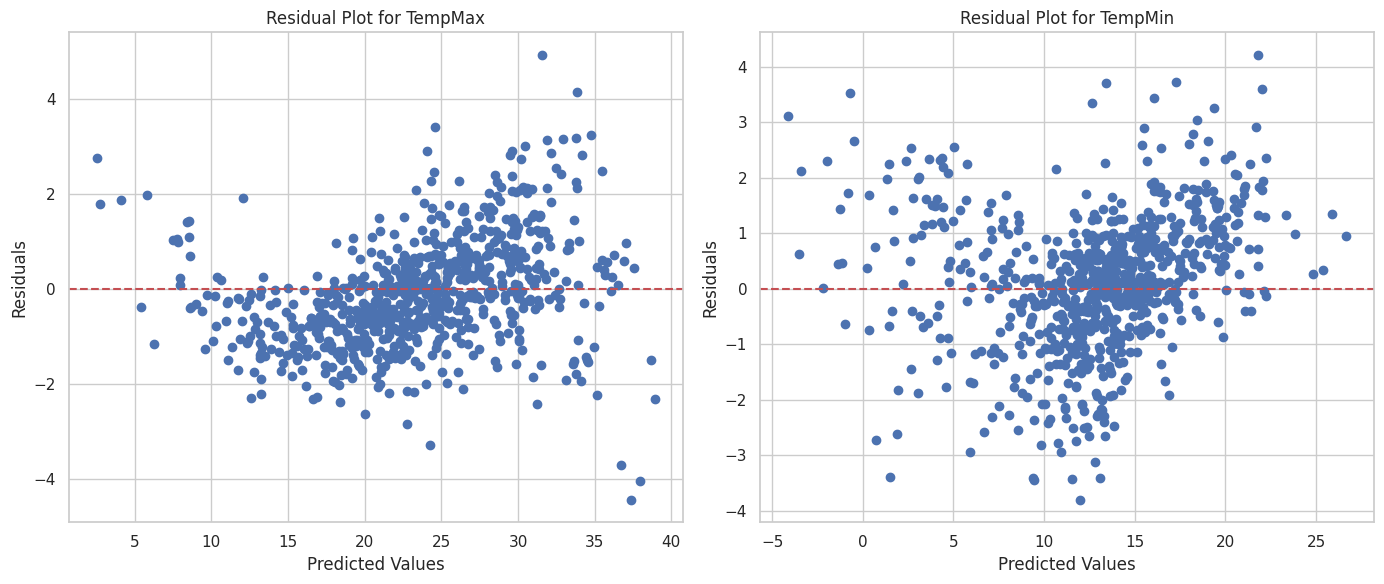

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual plots for TempMax
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test_max, residuals_max)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for TempMax')

# Residual plots for TempMin
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test_min, residuals_min)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for TempMin')

plt.tight_layout()
plt.show()


In [402]:
from statsmodels.stats.stattools import durbin_watson

# Compute Durbin-Watson statistic
dw_stat_max = durbin_watson(residuals_max)
dw_stat_min = durbin_watson(residuals_min)

print(f'Durbin-Watson Statistic for TempMax Residuals: {dw_stat_max}')
print(f'Durbin-Watson Statistic for TempMin Residuals: {dw_stat_min}')

Durbin-Watson Statistic for TempMax Residuals: 1.0732950874434735
Durbin-Watson Statistic for TempMin Residuals: 1.3689056686670025


## Feature Importance

In [403]:
# Feature importances for TempMax
importance_max = ridge_model_max.coef_
features_max = X_train_max.columns
importance_df_max = pd.DataFrame({'Feature': features_max, 'Importance': importance_max}).sort_values(by='Importance', ascending=False)
print("Feature Importances for TempMax:")
print(importance_df_max)

# Feature importances for TempMin
importance_min = ridge_model_min.coef_
features_min = X_train_min.columns
importance_df_min = pd.DataFrame({'Feature': features_min, 'Importance': importance_min}).sort_values(by='Importance', ascending=False)
print("Feature Importances for TempMin:")
print(importance_df_min)


Feature Importances for TempMax:
                  Feature  Importance
0  feelslike_max_combined   13.381551
2                    snow    0.099548
3               snowdepth    0.048089
1            dew_humidity   -1.151870
Feature Importances for TempMin:
                  Feature  Importance
0  feelslike_min_combined   10.437274
1            dew_humidity    1.016141
2               snowdepth    0.023717


In [404]:
# Feature importances for tempmax
importances_max = abs(ridge_model_max.coef_)
importance_df_max = pd.DataFrame({
    'Feature': X_train_max.columns,
    'Importance': importances_max
}).sort_values(by='Importance', ascending=False)

# Feature importances for tempmin
importances_min = abs(ridge_model_min.coef_)
importance_df_min = pd.DataFrame({
    'Feature': X_train_min.columns,
    'Importance': importances_min
}).sort_values(by='Importance', ascending=False)

print("Feature Importances from Ridge Regression for tempmax:")
print(importance_df_max)

print("Feature Importances from Ridge Regression for tempmin:")
print(importance_df_min)

Feature Importances from Ridge Regression for tempmax:
                  Feature  Importance
0  feelslike_max_combined   13.381551
1            dew_humidity    1.151870
2                    snow    0.099548
3               snowdepth    0.048089
Feature Importances from Ridge Regression for tempmin:
                  Feature  Importance
0  feelslike_min_combined   10.437274
1            dew_humidity    1.016141
2               snowdepth    0.023717


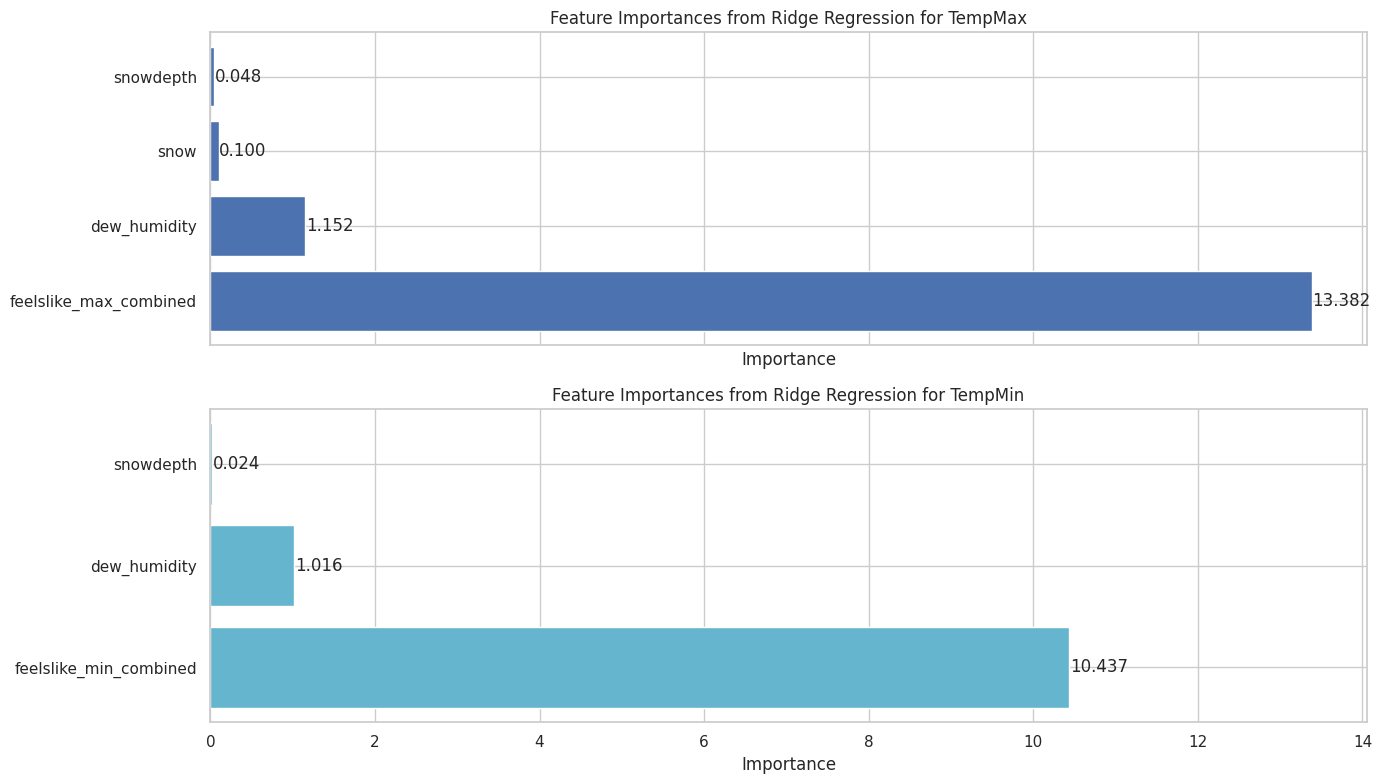

In [405]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# TempMax Plot
ax1.barh(importance_df_max['Feature'], importance_df_max['Importance'], color=color_pal[0])
ax1.set_title('Feature Importances from Ridge Regression for TempMax')
ax1.set_xlabel('Importance')
for index, value in enumerate(importance_df_max['Importance']):
    ax1.text(value + 0.01, index, f'{value:.3f}', va='center')

# TempMin Plot
ax2.barh(importance_df_min['Feature'], importance_df_min['Importance'], color=color_pal[9])
ax2.set_title('Feature Importances from Ridge Regression for TempMin')
ax2.set_xlabel('Importance')
for index, value in enumerate(importance_df_min['Importance']):
    ax2.text(value + 0.01, index, f'{value:.3f}', va='center')

# Adjust layout
plt.tight_layout()
plt.show()

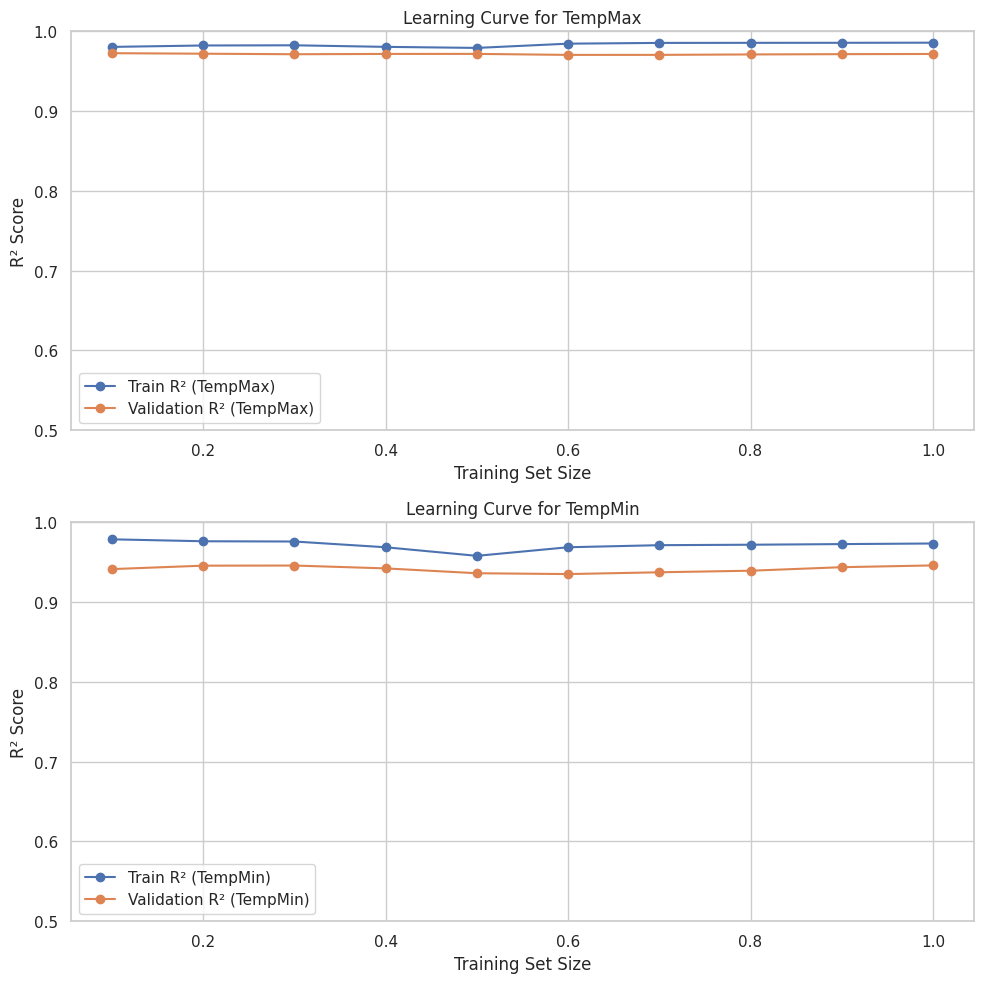

In [406]:
# List to store results
train_sizes = np.linspace(0.1, 1.0, 10)
train_r2_max = []
val_r2_max = []
train_r2_min = []
val_r2_min = []

for train_size in train_sizes:
    # Calculate the number of samples for the current training subset size
    subset_size_max = int(train_size * len(X_train_max_scaled))
    subset_size_min = int(train_size * len(X_train_min_scaled))

    # Create training subsets
    X_train_max_subset = X_train_max_scaled[:subset_size_max]
    y_train_max_subset = y_train_max.iloc[:subset_size_max]

    X_train_min_subset = X_train_min_scaled[:subset_size_min]
    y_train_min_subset = y_train_min.iloc[:subset_size_min]

    # Initialize and fit the Ridge Regression model
    ridge_model_max = Ridge(alpha=best_alpha_max)
    ridge_model_max.fit(X_train_max_subset, y_train_max_subset)

    ridge_model_min = Ridge(alpha=best_alpha_min)
    ridge_model_min.fit(X_train_min_subset, y_train_min_subset)

    # Predict and evaluate
    y_train_pred_max = ridge_model_max.predict(X_train_max_subset)
    y_val_pred_max = ridge_model_max.predict(X_test_max_scaled)

    y_train_pred_min = ridge_model_min.predict(X_train_min_subset)
    y_val_pred_min = ridge_model_min.predict(X_test_min_scaled)

    # Compute R²
    train_r2_max.append(r2_score(y_train_max_subset, y_train_pred_max))
    val_r2_max.append(r2_score(y_test_max, y_val_pred_max))

    train_r2_min.append(r2_score(y_train_min_subset, y_train_pred_min))
    val_r2_min.append(r2_score(y_test_min, y_val_pred_min))

# Plot learning curves
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# TempMax Learning Curve
ax[0].plot(train_sizes, train_r2_max, label='Train R² (TempMax)', marker='o')
ax[0].plot(train_sizes, val_r2_max, label='Validation R² (TempMax)', marker='o')
ax[0].set_title('Learning Curve for TempMax')
ax[0].set_xlabel('Training Set Size')
ax[0].set_ylabel('R² Score')
ax[0].legend()
ax[0].grid(True)
ax[0].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMax

# TempMin Learning Curve
ax[1].plot(train_sizes, train_r2_min, label='Train R² (TempMin)', marker='o')
ax[1].plot(train_sizes, val_r2_min, label='Validation R² (TempMin)', marker='o')
ax[1].set_title('Learning Curve for TempMin')
ax[1].set_xlabel('Training Set Size')
ax[1].set_ylabel('R² Score')
ax[1].legend()
ax[1].grid(True)
ax[1].set_ylim(0.5, 1.0)  # Set y-axis limit for TempMin

plt.tight_layout()
plt.show()

## Autocorrelation

In [408]:
import pmdarima as pm
from statsmodels.stats.stattools import durbin_watson
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Auto ARIMA to find best model orders
stepwise_fit_max = pm.auto_arima(y_train_max, exogenous=X_train_max, trace=True, suppress_warnings=True)
stepwise_fit_min = pm.auto_arima(y_train_min, exogenous=X_train_min, trace=True, suppress_warnings=True)

print("------------------- ARIMA MAX -----------------")
print(stepwise_fit_max.summary())
print("------------------- ARIMA MIN -----------------")
print(stepwise_fit_min.summary())

# Train and fit the models on best orders based on auto_arima results
arima_max = ARIMA(y_train_max, order=stepwise_fit_max.order, exog=X_train_max)
arima_max = arima_max.fit()
print(arima_max.summary())

arima_min = ARIMA(y_train_min, order=stepwise_fit_min.order, exog=X_train_min)
arima_min = arima_min.fit()
print(arima_min.summary())

# Define start and end points for prediction
start = len(y_train_max)
end = start + len(y_test_max) - 1

# Predict using the ARIMA models
arima_pred_max = arima_max.predict(start=start, end=end, exog=X_test_max, typ='levels')
arima_pred_min = arima_min.predict(start=start, end=end, exog=X_test_min, typ='levels')

# Ensure the predictions have the correct index
arima_pred_max.index = y_test_max.index
arima_pred_min.index = y_test_min.index


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13808.687, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14006.872, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13974.708, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13957.591, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14004.881, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13806.756, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13860.258, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13812.153, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13808.598, Time=1.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13823.072, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13807.058, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13810.736, Time=0.85 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13804.805, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13858.278, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0

RMSE for ARIMA TempMax: 1.2307347196117897
RMSE for ARIMA TempMin: 1.4063250527887454


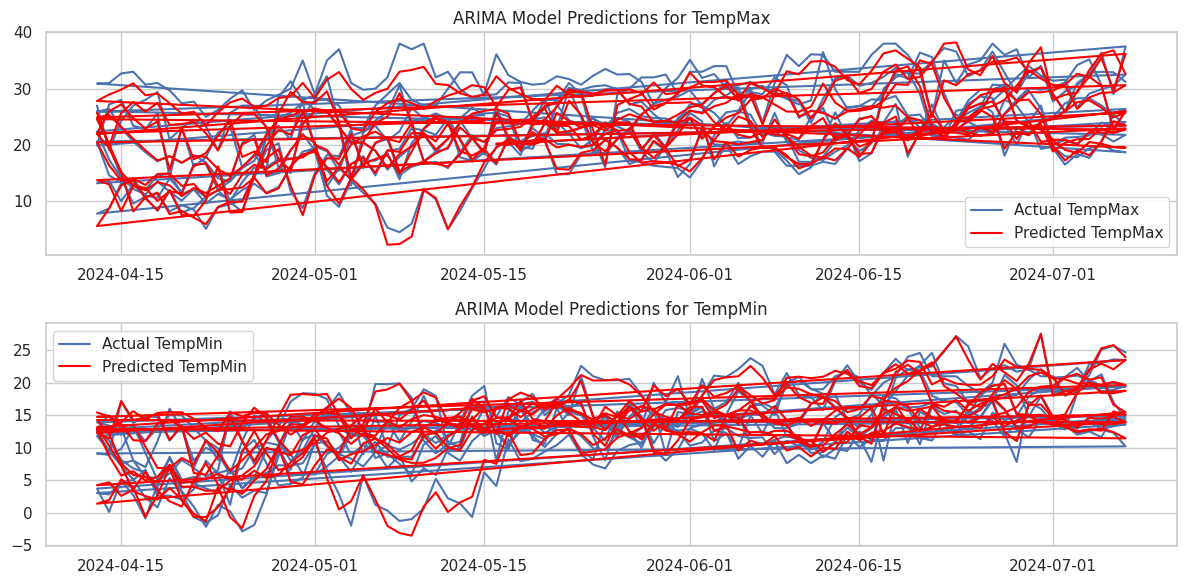

In [411]:
# Calculate RMSE for TempMax
rmse_max = np.sqrt(mean_squared_error(y_test_max, arima_pred_max))
print(f'RMSE for ARIMA TempMax: {rmse_max}')

# Calculate RMSE for TempMin
rmse_min = np.sqrt(mean_squared_error(y_test_min, arima_pred_min))
print(f'RMSE for ARIMA TempMin: {rmse_min}')

# Plot the predicted ARIMA values against the validate values
plt.figure(figsize=(12, 6))

# TempMax predictions
plt.subplot(2, 1, 1)
plt.plot(y_test_max, label='Actual TempMax')
plt.plot(arima_pred_max, label='Predicted TempMax', color='red')
plt.title('ARIMA Model Predictions for TempMax')
plt.legend()

# TempMin predictions
plt.subplot(2, 1, 2)
plt.plot(y_test_min, label='Actual TempMin')
plt.plot(arima_pred_min, label='Predicted TempMin', color='red')
plt.title('ARIMA Model Predictions for TempMin')
plt.legend()

plt.tight_layout()
plt.show()

In [410]:
from statsmodels.stats.stattools import durbin_watson

# Compute Durbin-Watson statistic
dw_stat_max = durbin_watson(residuals_max)
dw_stat_min = durbin_watson(residuals_min)

print(f'Durbin-Watson Statistic for TempMax Residuals: {dw_stat_max}')
print(f'Durbin-Watson Statistic for TempMin Residuals: {dw_stat_min}')


Durbin-Watson Statistic for TempMax Residuals: 1.0732950874434735
Durbin-Watson Statistic for TempMin Residuals: 1.3689056686670025


## Cross Validation Before Completion

# Next steps:
- Residual Analysis, no remaining heteroskedasticity issues
- Autocorrelation fix
- Test final model evaluation/maybe try time series models
- Rename variables and clean/simplify notebook
- Documentation and Reporting
- Plot predicted vs actual value